In [2]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
import requests
from IPython.core.display import HTML
def css_style(url):
    style = requests.get(url)
    return HTML(style.text)
css_style('https://raw.githubusercontent.com/saadtony/NumericalMethods/master/styles/custom.css')

# Heating a rod, Dirichlet boundary conditions

For a boundary value problem, we will look at a rod heated at both ends, with a fluid flowing over the rod. The differential equation governing this system is:

$$\frac{d^{2}T}{dx^{2}} =\frac{hP}{\lambda A_{c}} (T-T_{\infty })$$

Discretizing the equation gives:

$$T_{i-1}-(2\  +\  \frac{hP}{\lambda A_{c}} \Delta x^{2})T_{i}+T_{i+1}=-\frac{hP}{\lambda A_{c}} \Delta x^{2}T_{\infty }$$

This gives the structure of a tri-diagonal matrix on the left.

In [75]:
n = 201
L = 1.          # rod length
dx = L/(n-1)
Tright = 300    # rod right temperature
Tleft = 300     # rod left temperature
Tinf = 500
x = np.linspace(0, L, n)
h = 10           # heat transfer coefficient

In [76]:
x[1]-x[0] == dx

True

In [77]:
ld = np.ones(n-1)
ld[-1] = 0
d = -np.ones(n)*(2+h*dx**2)
d[0] = 1     # Boundary condition
d[-1] = 1
ud = np.ones(n-1)
ud[0] = 0
A = np.diag(ld, -1) + np.diag(d) + np.diag(ud, 1)

In [78]:
rhs = np.ones(n)*(-h*dx**2*Tinf)
rhs[0] = Tleft
rhs[-1] = Tright

In [79]:
sol = np.linalg.solve(A, rhs)

No handles with labels found to put in legend.


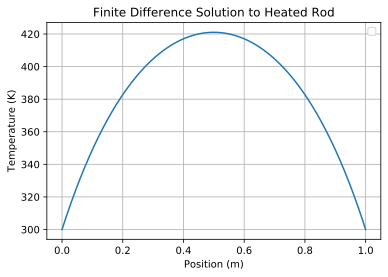

In [80]:
plt.plot(x, sol)
plt.title('Finite Difference Solution to Heated Rod')
plt.xlabel('Position (m)')
plt.ylabel('Temperature (K)')
plt.grid()

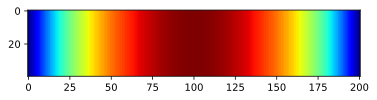

In [82]:
temp = np.tile(sol, (40,1))
plt.imshow(temp, cmap='jet')

# Heating a rod, Dirichlet and Neumann boundary conditions

On the right end, where the Neumann boundary condition exists:

$$\frac{dT_n}{dx} = \beta$$

we will modify the governing equation to account for the fact that an $n+1$ term appears in the discretized ODE, but an $n+1$ point does not exist. We can incorporate a ghost point, which adds one more unknown, and we can use the Neumann boundary condition to add one more equation. Discrerizing with a forward difference at the right end of the bar:

$$T_{n+1} = T_{n-1} + 2\Delta x*\beta$$

This makes the last row of the system:

$$2T_{n-1}-(2\  +\  \frac{hP}{\lambda A_{c}} \Delta x^{2})T_{i}=-\frac{hP}{\lambda A_{c}} \Delta x^{2}T_{\infty }-2\beta \Delta x$$

In [96]:
n = 201
L = 1.          # rod length
dx = L/(n-1)
β = -100.          # K/m
Tleft = 300     # rod left temperature
Tinf = 500
x = np.linspace(0, L, n)
h = 10   
ld = np.ones(n-1)
ld[-1] = 2.
d = -np.ones(n)*(2+h*dx**2)
d[0] = 1.     
ud = np.ones(n-1)
ud[0] = 0
A = np.diag(ld, -1) + np.diag(d) + np.diag(ud, 1)
rhs = np.ones(n)*(-h*dx**2*Tinf)
rhs[0] = Tleft
rhs[-1] = -h*dx**2*Tinf - 2*β*dx

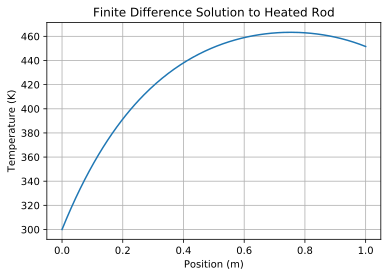

In [97]:
sol = np.linalg.solve(A, rhs)
plt.plot(x, sol)
plt.title('Finite Difference Solution to Heated Rod')
plt.xlabel('Position (m)')
plt.ylabel('Temperature (K)')
plt.grid()

# Source term linearization

In the radiative heat transfer example, the discretization of the governing equation leads to a system of nonlinear equations:

$$\frac{d^{2}T}{dx^{2}} =\alpha \left( T^{4}-T^{4}_{\infty }\right)  $$

$$\frac{T_{i-1}-2T_{i}+T_{i+1}}{\Delta x^{2}} =\alpha \left( T^{4}-T^{4}_{\infty }\right) $$

To correct this, the right-hand side will be written as a truncated Taylor series:

$$f(T)\  \approx \  f(T^*)\  +\  (T-T^*)\frac{df}{dT} \bigg|_{T^*}$$

where $T^*$ is a guess solution. In this case, the Taylor Series evaluates to:

$$f(T)\  \approx \  \alpha (T^{*4}-T^{4}_{\infty })\  +\  (T-T^*)* 4\alpha T^{*3}$$

$T$ is the unknown quantity, and $T^*$ is a guess, so now the source term is linearized, and $T^*$ will be refined until $T$ is found.

$$\alpha (T^{4}-T^{4}_{\infty })\  \approx \  -3\alpha T^{*4}+4\alpha T^{*3}T-\alpha T^{4}_{\infty }$$

Therefore, the ODE becomes:

$$\frac{d^2T}{dx^2} \approx \  -3\alpha T^{*4}+4\alpha T^{*3}T-\alpha T^{4}_{\infty }$$

$$\frac{T_{i-1}-2T_{i}+T_{i+1}}{\Delta x^{2}} \  \approx \  -3\alpha (T^{*}_{i})^{4}+4\alpha (T^{*}_{i})^{3}T_{i}-\alpha T^{4}_{\infty }$$

$$T_{i-1}-\left[ 2+4\alpha \Delta x^{2}(T^{*}_{i})^{3}\right]  T_{i}+T_{i+1}=-\alpha \Delta x^{2}\left[ 3(T^{*}_{i})^{4}+T^{4}_{\infty }\right]  $$

In [145]:
n = 201
L = 1.          # rod length
dx = L/(n-1)
α = 1e-8          # K/m
Tleft = 300     # rod left temperature
Tright = 300
Tinf = 500
Tstar = np.ones(n)*200 # Vector of initial guesses
x = np.linspace(0, L, n)  
# Building the coefficient matrix
ld = np.ones(n-1)
ld[-1] = 0.  # Dirichlet boundry
ud = np.ones(n-1)
ud[0] = 0    # Dirichlet boundary
d = -np.ones(n)*(2+4*α*dx**2*Tstar**3)
d[0] = 1.    # Dirichlet boundary    
d[-1] = 1.   # Dirichlet boundary
A = np.diag(ld, -1) + np.diag(d) + np.diag(ud, 1)
rhs = np.ones(n)*(-α*dx**2)*(3*Tstar**4 + Tinf**4)
rhs[0] = Tleft
rhs[-1] = Tright

In [146]:
tol = 1e-3
err = 100
niter = 0
while err > tol:
    Tsol = np.linalg.solve(A, rhs)
    err = np.linalg.norm(Tstar-Tsol, 2)
    Tstar = Tsol
    ld = np.ones(n-1)
    ld[-1] = 0.  # Dirichlet boundry
    ud = np.ones(n-1)
    ud[0] = 0    # Dirichlet boundary
    d = -np.ones(n)*(2+4*α*dx**2*Tstar**3)
    d[0] = 1.    # Dirichlet boundary    
    d[-1] = 1.   # Dirichlet boundary
    A = np.diag(ld, -1) + np.diag(d) + np.diag(ud, 1)
    rhs = np.ones(n)*(-α*dx**2)*(3*Tstar**4 + Tinf**4)
    rhs[0] = Tleft
    rhs[-1] = Tright
    niter += 1

In [154]:
def build_coeff_mat(*args):
    Tleft, Tright, α, n, Tinf, Tstar = args
    # Building the coefficient matrix
    ld = np.ones(n-1)
    ld[-1] = 0.  # Dirichlet boundry
    ud = np.ones(n-1)
    ud[0] = 0    # Dirichlet boundary
    d = -np.ones(n)*(2+4*α*dx**2*Tstar**3)
    d[0] = 1.    # Dirichlet boundary    
    d[-1] = 1.   # Dirichlet boundary
    A = np.diag(ld, -1) + np.diag(d) + np.diag(ud, 1)
    rhs = np.ones(n)*(-α*dx**2)*(3*Tstar**4 + Tinf**4)
    rhs[0] = Tleft
    rhs[-1] = Tright
    
    return A, rhs
    
def iterate(*args, tol):
    Tleft, Tright, α, n, Tinf, Tstar = args
    err = 100
    A, rhs = build_coeff_mat(Tleft, Tright, α, n, Tinf, Tstar)
    niter = 0
    while err > tol:
        Tsol = np.linalg.solve(A, rhs)
        err = np.linalg.norm(Tsol-Tstar, 2)
        Tstar = Tsol
        A, rhs = build_coeff_mat(Tleft, Tright, α, n, Tinf, Tstar)
        niter += 1
    return Tsol, err, niter

In [173]:
n = 201
L = 1.          # rod length
dx = L/(n-1)
α = 1e-8          # K/m
Tleft = 300     # rod left temperature
Tright = 300
Tinf = 595
Tstar = np.ones(n)*200 # Vector of initial guesses
x = np.linspace(0, L, n)  
Tsol, err, niter = iterate(Tleft, Tright, α, n, Tinf, Tstar, tol=1e-6)

Text(0.5, 1.0, 'Source term linearization, final err: 3.7341e-10, iterations: 5')

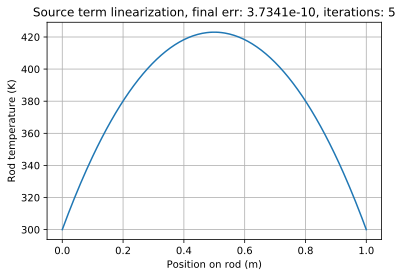

In [174]:
plt.plot(x, Tsol)
plt.xlabel('Position on rod (m)')
plt.ylabel('Rod temperature (K)')
plt.grid()
plt.title(f'Source term linearization, final err: {err:.4e}, iterations: {niter}')

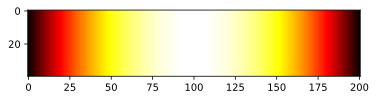

In [184]:
temps = np.tile(Tsol, (40,1))
plt.imshow(temps, cmap='hot')